In [ ]:
#importing the required frameworks and modules
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import models, utils
from torch.autograd import Variable

import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [ ]:
#Sets a manual seed for the random number generator in PyTorch
#to help ensure repeatable results.
torch.manual_seed(73)

# Loads the MNIST dataset for handwritten digit classification,
# automatically downloading it if needed and transforming the data into Tensors.
# Splits into training and test sets.


train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())


# Specifies a batch size
# creates PyTorch DataLoader objects to iterate through data in batches
# shuffle for training.


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Defines a Convolutional Neural Network class inheriting from nn.Module.

#  a convolutional layer (4 kernels of 7x7, with a stride of 3x3),
#  a linear layer (input: 256, output: 64),
#  and a final linear layer (input: 64, output: 10).

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        # the model uses the square activation function
        x = x * x
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x

In [ ]:

# Trains the neural network by iterating through data, calculating loss, backpropagating,
# and updating weights.

def train(model, train_loader, criterion, optimizer, n_epochs=10):
    # model in training mode
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    # model in evaluation mode
    model.eval()
    return model


In [ ]:
# Instantiates the model, loss criterion, optimizer,
#  and trains the model.

model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.397561
Epoch: 2 	Training Loss: 0.130699
Epoch: 3 	Training Loss: 0.088399
Epoch: 4 	Training Loss: 0.071318
Epoch: 5 	Training Loss: 0.058989
Epoch: 6 	Training Loss: 0.050542
Epoch: 7 	Training Loss: 0.044438
Epoch: 8 	Training Loss: 0.038261
Epoch: 9 	Training Loss: 0.034641
Epoch: 10 	Training Loss: 0.030696


# Test the model


In [ ]:
#print the test data's lables

print(test_data.targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [ ]:
# Tests the trained model on the test set, calculating accuracy metrics.

def test(model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # model in evaluation mode
    model.eval()

    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )



In [ ]:
test(model, test_loader, criterion)

Test Loss: 0.088565

Test Accuracy of 0: 98% (966/980)
Test Accuracy of 1: 99% (1130/1135)
Test Accuracy of 2: 98% (1015/1032)
Test Accuracy of 3: 99% (1002/1010)
Test Accuracy of 4: 98% (967/982)
Test Accuracy of 5: 98% (878/892)
Test Accuracy of 6: 98% (944/958)
Test Accuracy of 7: 98% (1011/1028)
Test Accuracy of 8: 96% (941/974)
Test Accuracy of 9: 96% (969/1009)

Test Accuracy (Overall): 98% (9823/10000)


In [ ]:
# Installs the TenSEAL library for encrypted operations
# and imports it as ts.


!pip install tenseal
import tenseal as ts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.1 MB/s eta 0:00:00


In [ ]:
"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convolution operation.
    - .square_() just square the encrypted vector inplace.
"""

# Defines a class EncConvNet that will perform operations on encrypted data,
# initializing the weights from the PyTorch ConvNet model.

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()

        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()


# Defines the forward pass on encrypted data using TenSEAL's vector operations.
# Performs convolutions, activations, matrix multiplications, etc.while keeping data encrypted.


    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)



        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)


        # ax.text(0,7,str(target))
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
# Defines a test function for the encrypted model.


def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # row = 1
    # col = 1

    for data, target in test_loader:
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
# print the input data
        fig=plt.figure(figsize=(15,15))
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
        images = np.reshape(data[0], [28,28])
        ax=fig.add_subplot(6,5,1,xticks=[],yticks=[])
        ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
        ax.text(0,7,"Input image: "+str(target))
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
# print the output layer
        fig=plt.figure(figsize=(15,7))
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
        images = np.reshape(output[0], [1,-1])
        ax=fig.add_subplot(27,6,1,xticks=[],yticks=[])
        ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
        ax.text(0,7,"Output image: "+str(target))




        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1



    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')
    for label in range(10):
      if class_total[label] !=0:
        print(
              f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
              f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
          )
      print(class_correct,class_total)
    if class_total !=0:
      print(
          f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
          f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
      )



In [ ]:
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:

from torch.utils.data import Subset
from torch.utils.data import DataLoader

#take only a fraction of the input data

fraction = 0.01 # Specify the fraction you want to use (e.g., 0.5 for 50% of the dataset)
num_samples = int(len(test_data) * fraction)
test_data_subset = Subset(test_data, range(num_samples))

test_loader = DataLoader(test_data_subset, batch_size=1,shuffle=True)
kernel_shape = model.conv1.kernel_size
stride = model.conv1.stride[0]

<ipython-input-11-7170b9906c22>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(15,15))


Test Loss: 0.008427

Test Accuracy of 0: 100% (8/8)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 1: 100% (14/14)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 2: 100% (8/8)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 3: 100% (11/11)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 4: 100% (14/14)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 5: 100% (7/7)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0]
Test Accuracy of 6: 100% (10/10)
[8.0, 14.0, 8.0, 11.0, 14.0, 7.0, 10.0, 15.0, 2.0, 11.0] [8.0, 14.0, 8

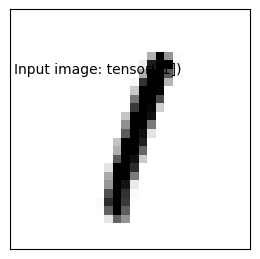

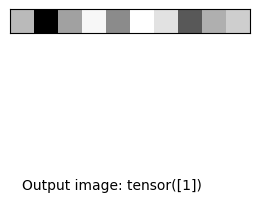

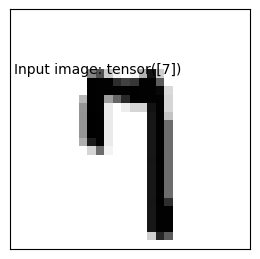

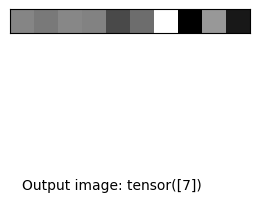

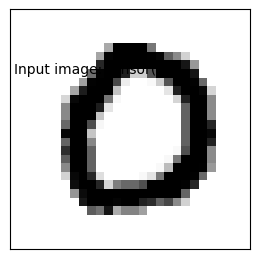

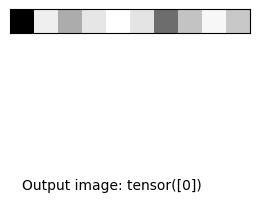

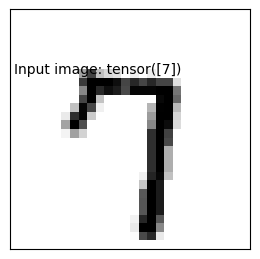

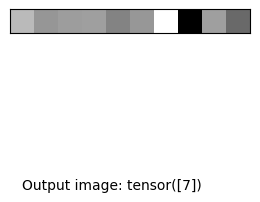

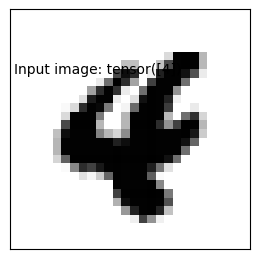

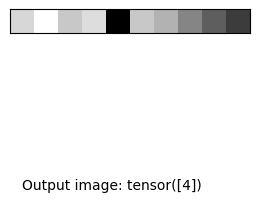

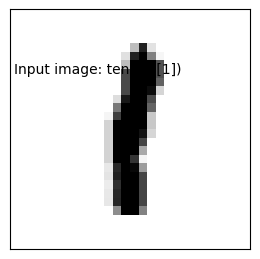

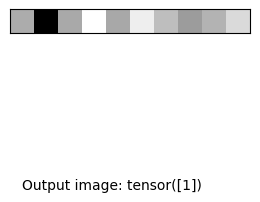

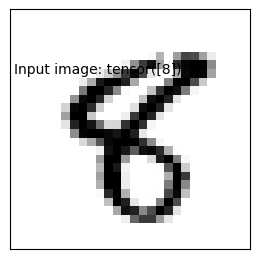

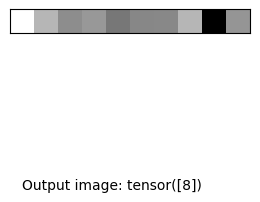

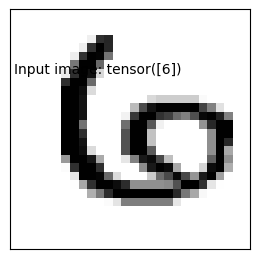

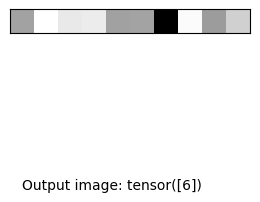

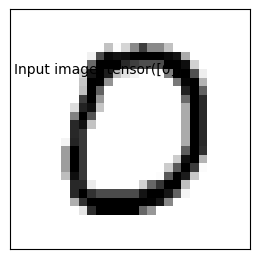

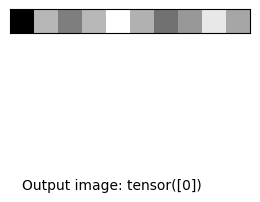

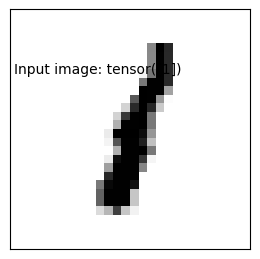

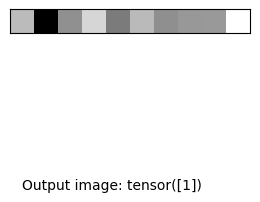

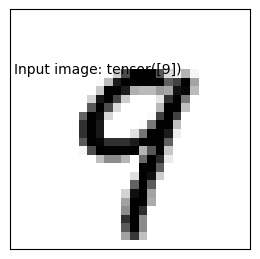

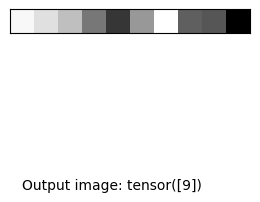

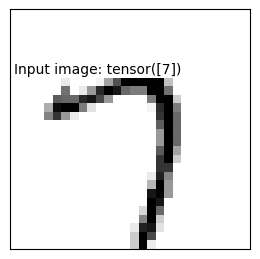

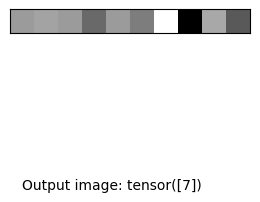

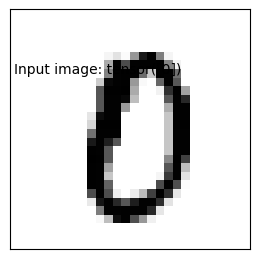

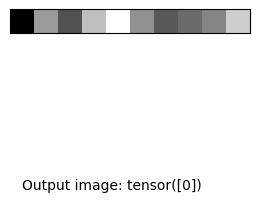

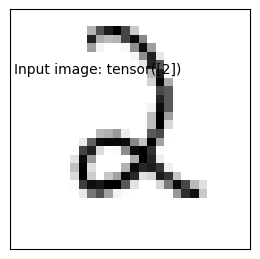

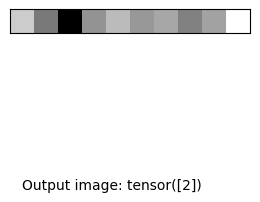

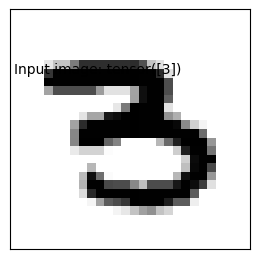

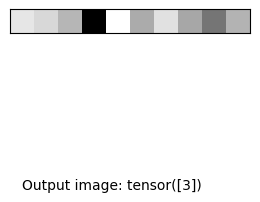

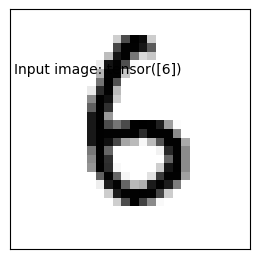

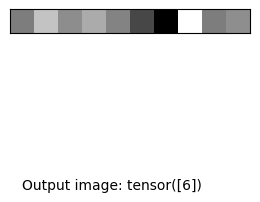

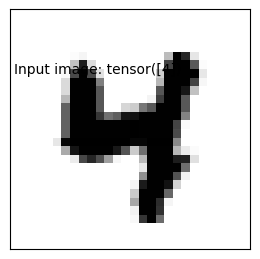

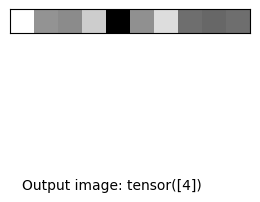

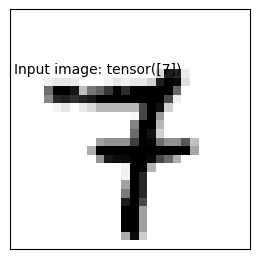

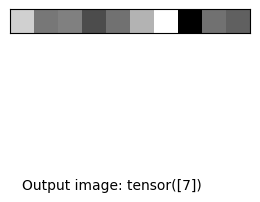

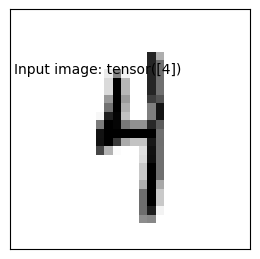

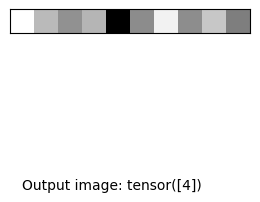

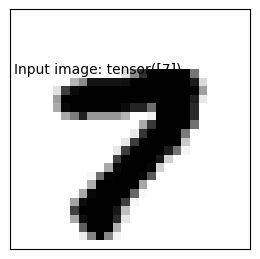

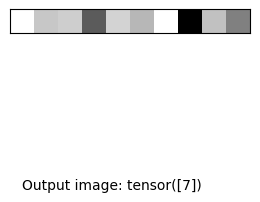

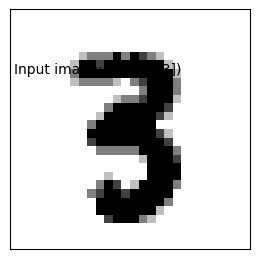

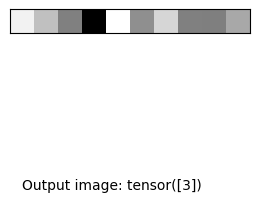

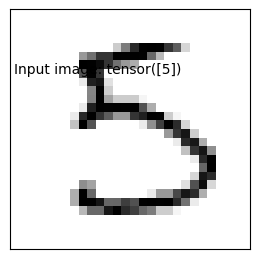

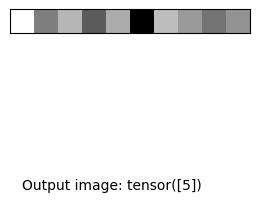

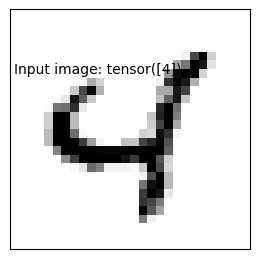

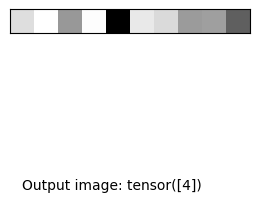

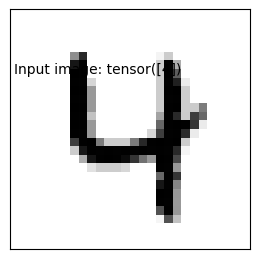

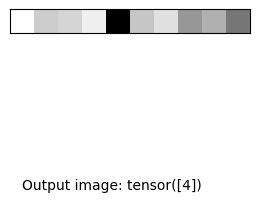

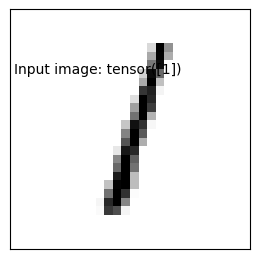

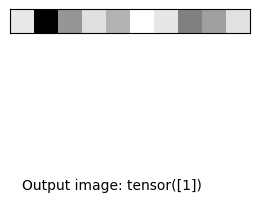

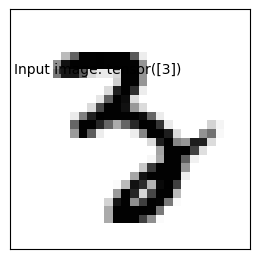

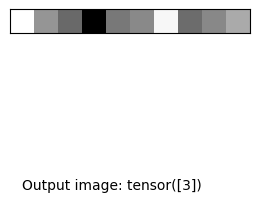

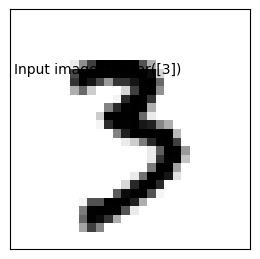

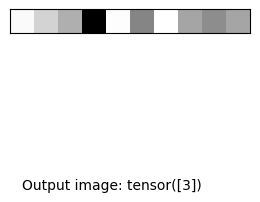

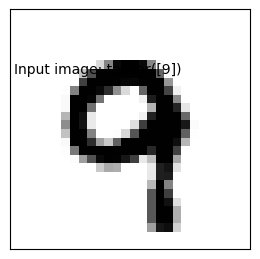

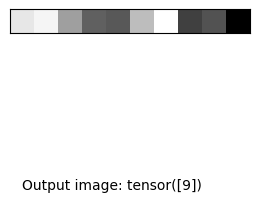

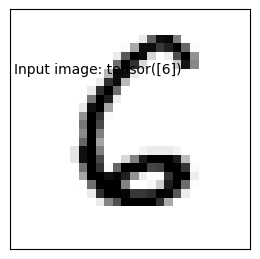

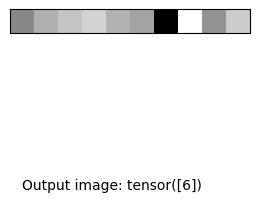

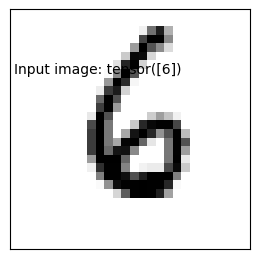

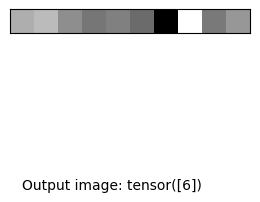

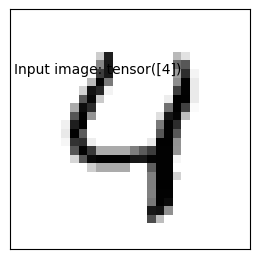

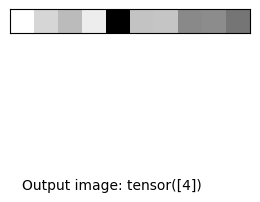

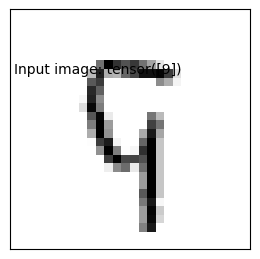

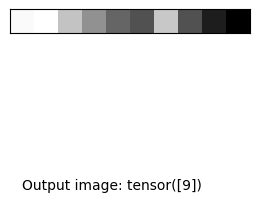

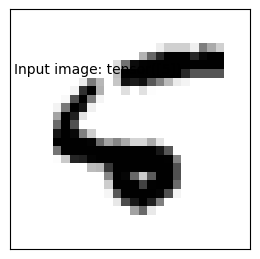

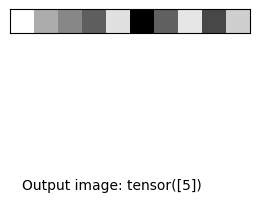

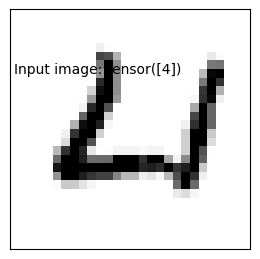

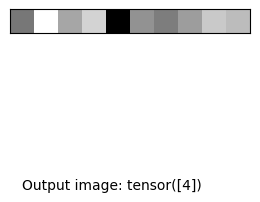

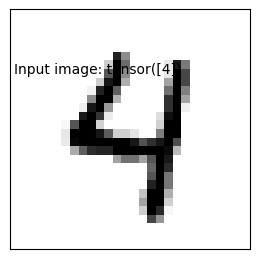

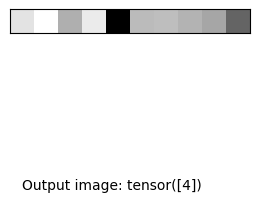

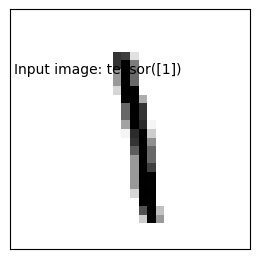

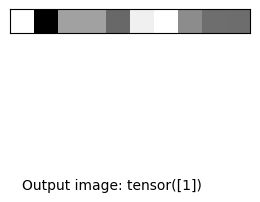

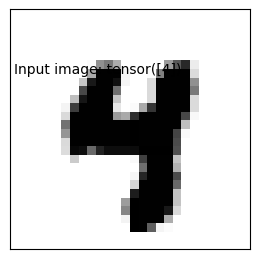

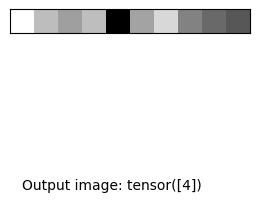

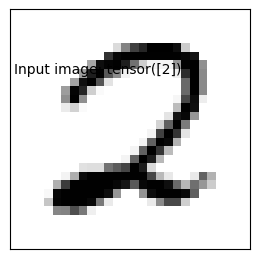

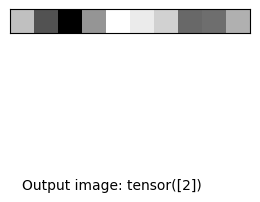

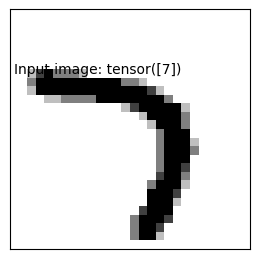

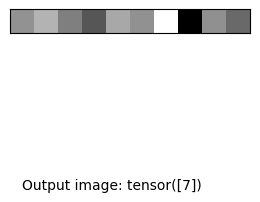

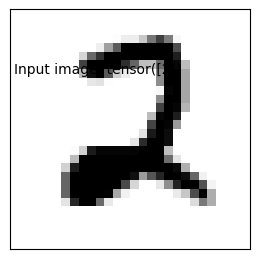

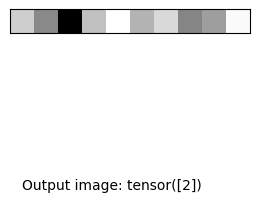

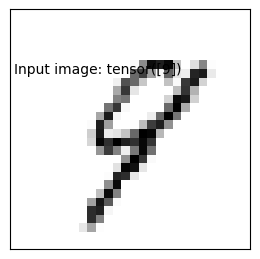

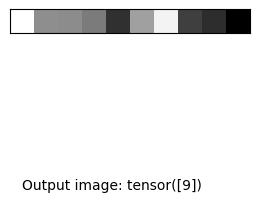

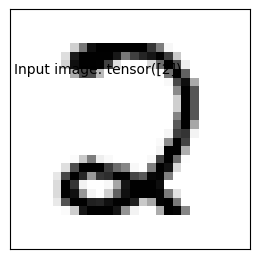

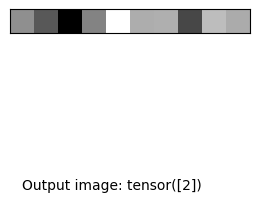

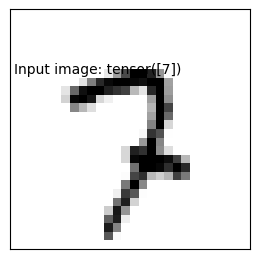

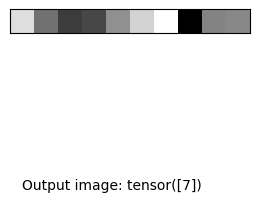

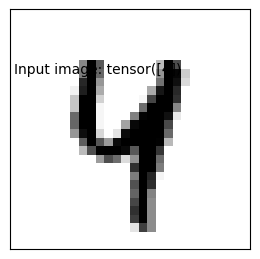

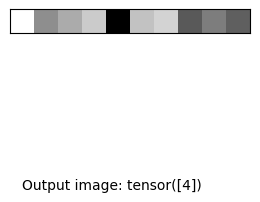

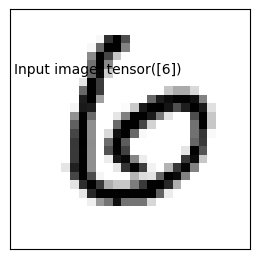

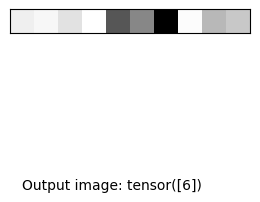

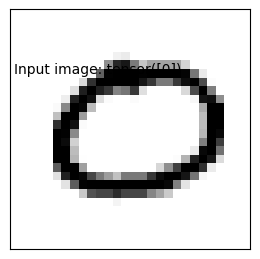

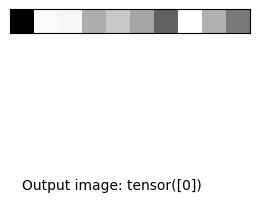

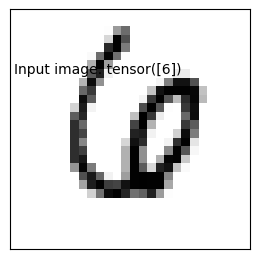

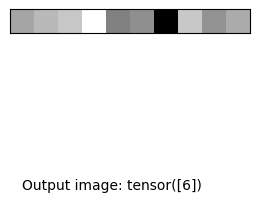

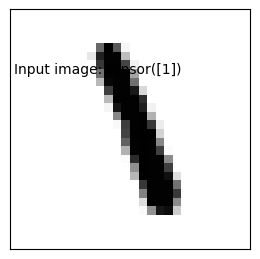

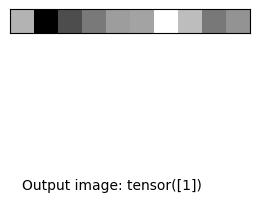

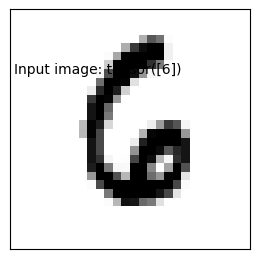

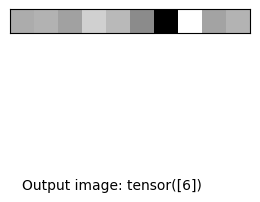

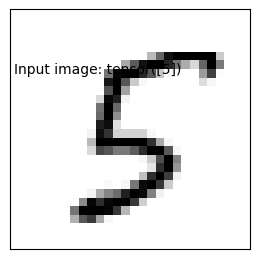

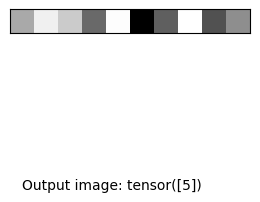

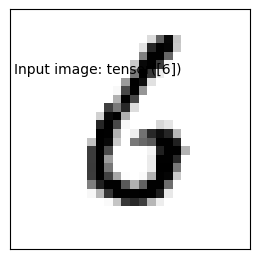

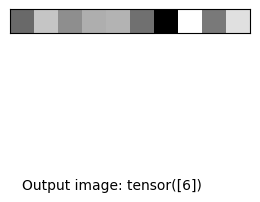

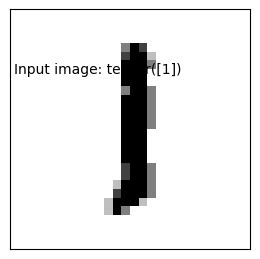

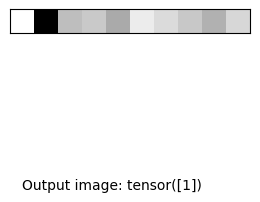

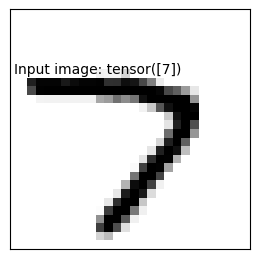

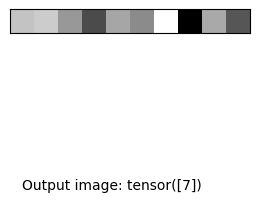

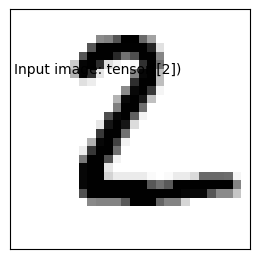

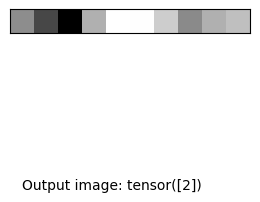

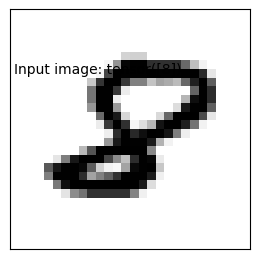

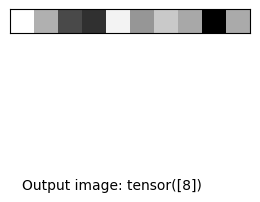

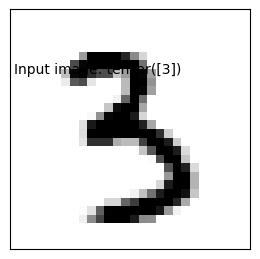

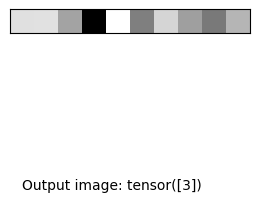

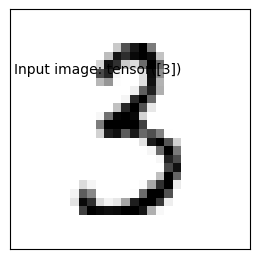

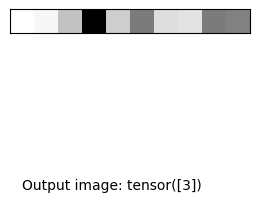

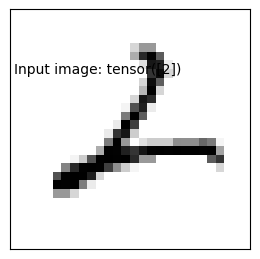

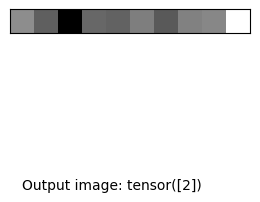

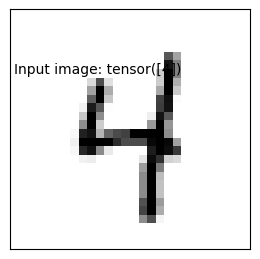

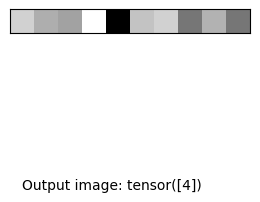

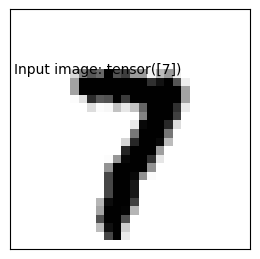

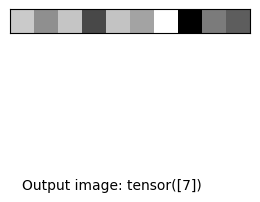

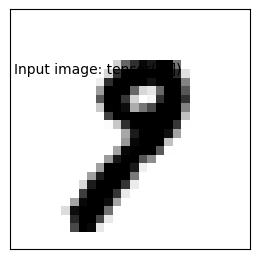

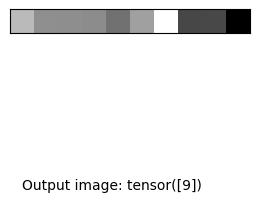

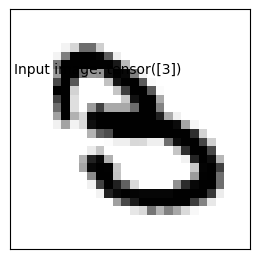

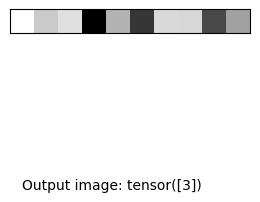

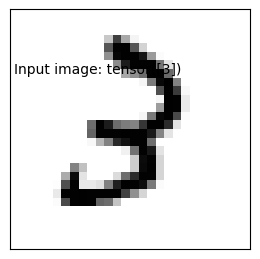

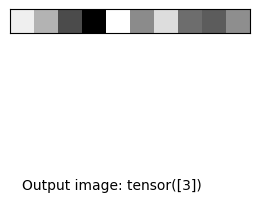

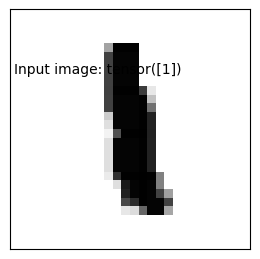

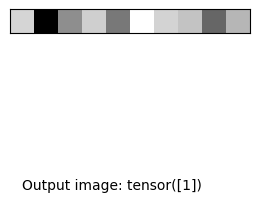

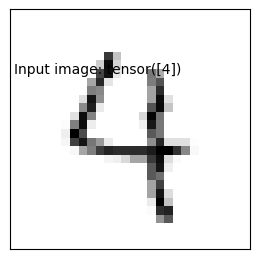

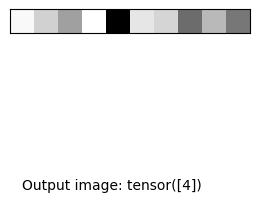

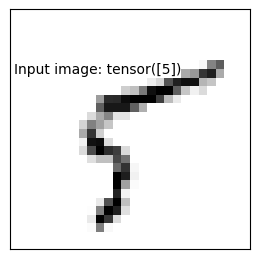

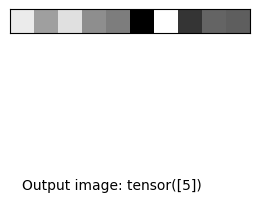

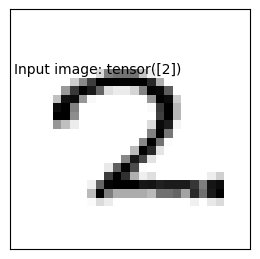

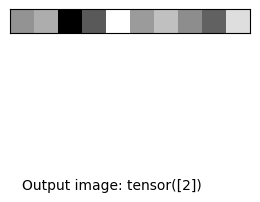

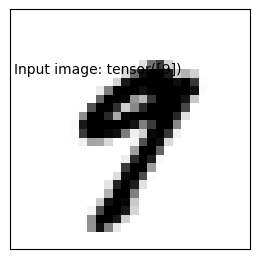

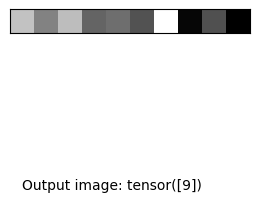

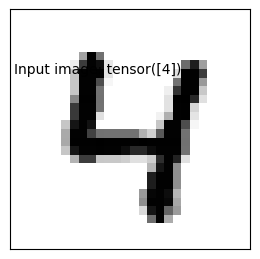

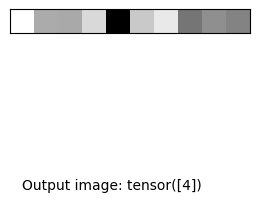

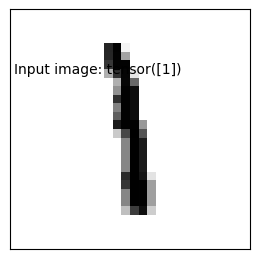

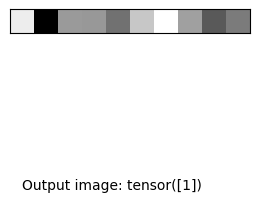

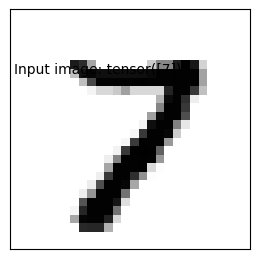

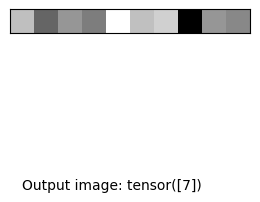

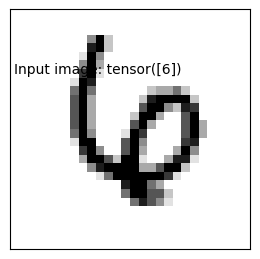

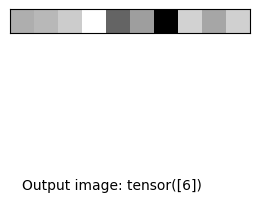

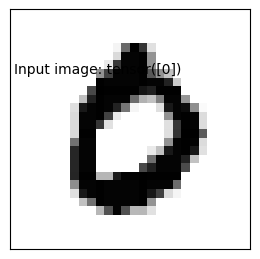

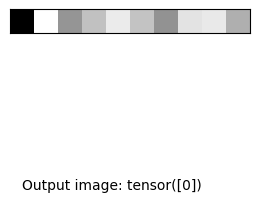

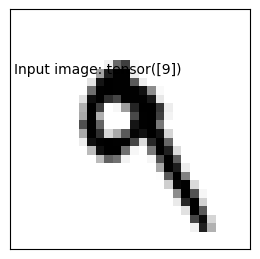

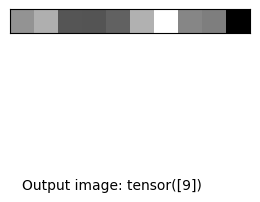

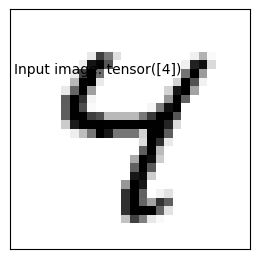

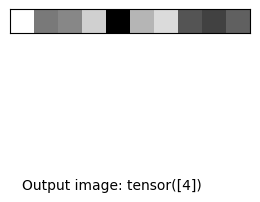

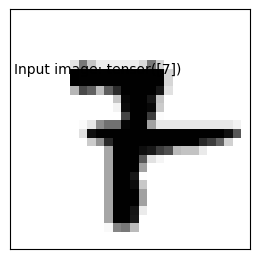

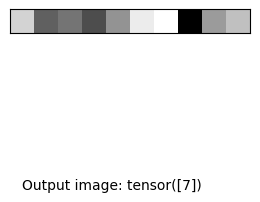

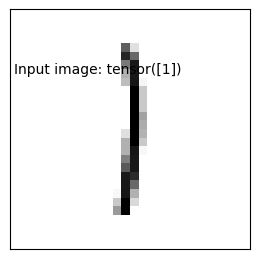

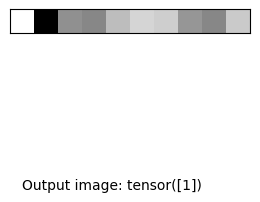

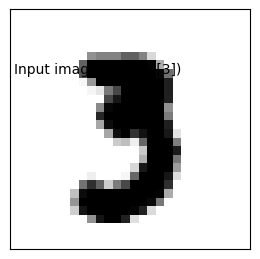

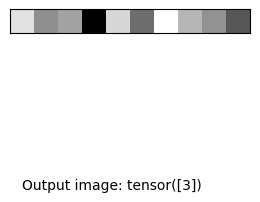

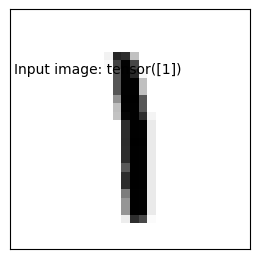

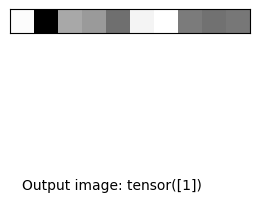

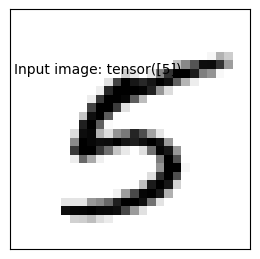

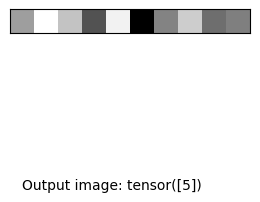

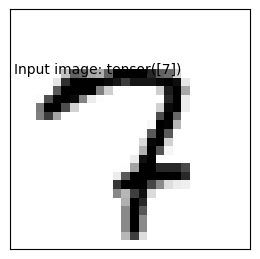

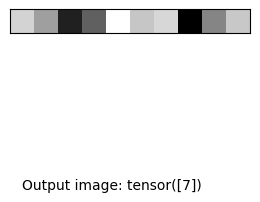

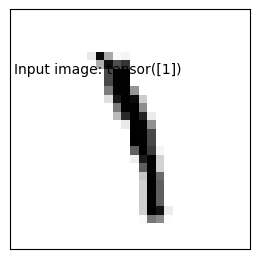

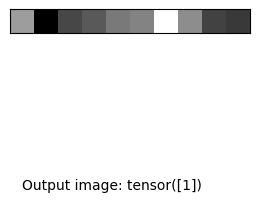

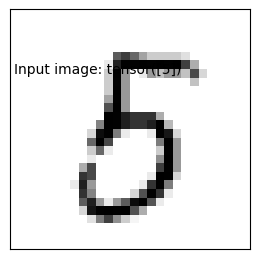

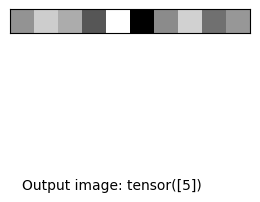

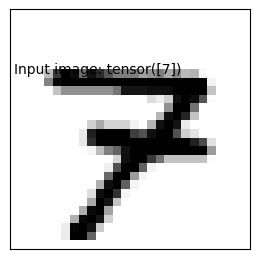

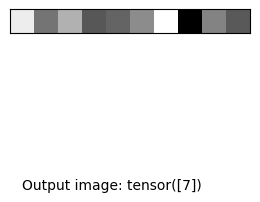

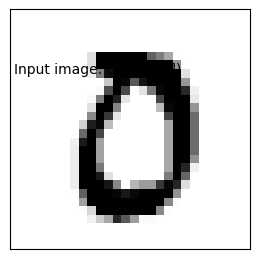

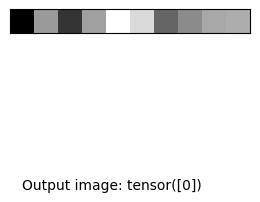

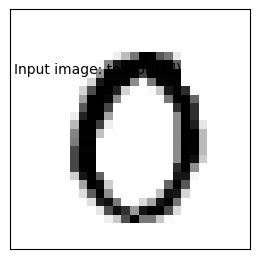

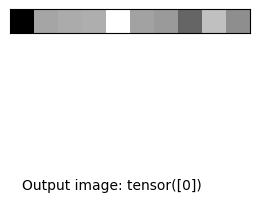

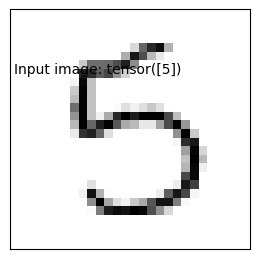

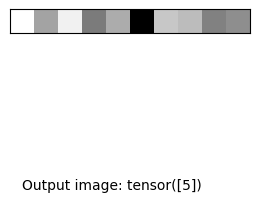

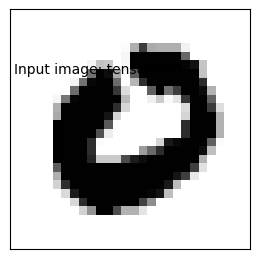

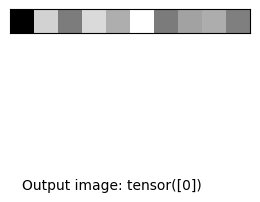

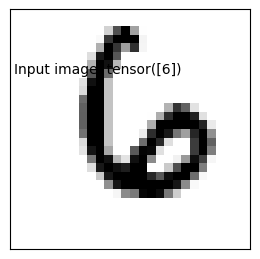

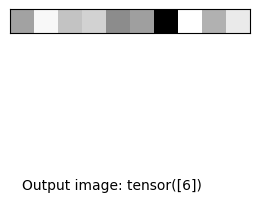

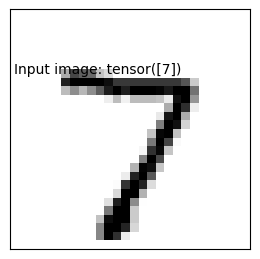

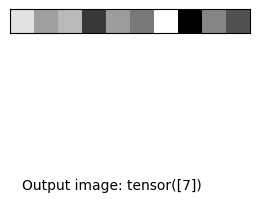

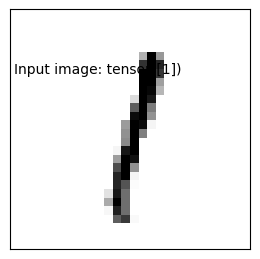

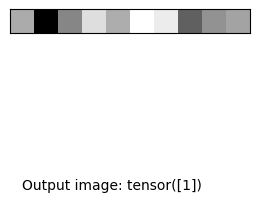

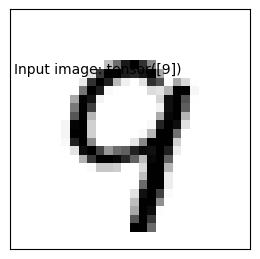

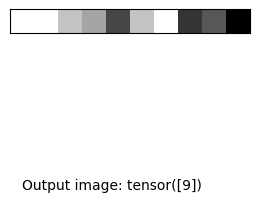

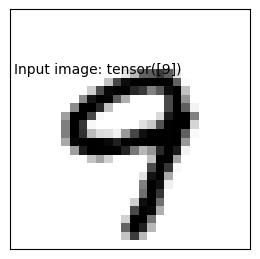

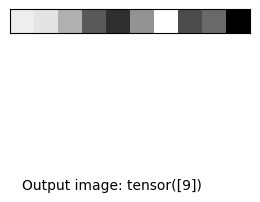

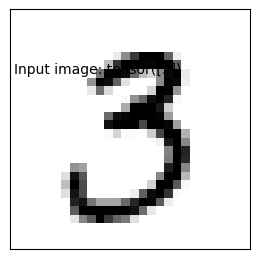

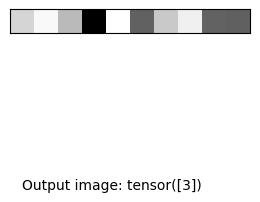

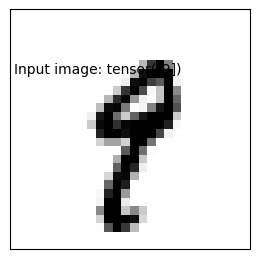

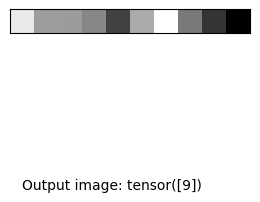

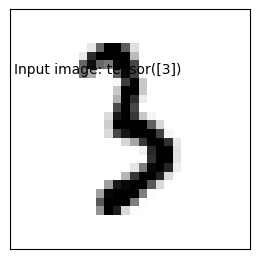

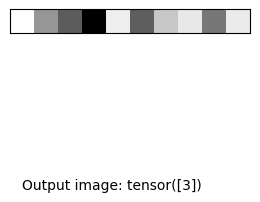

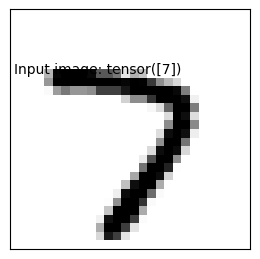

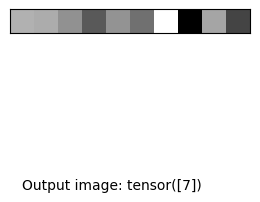

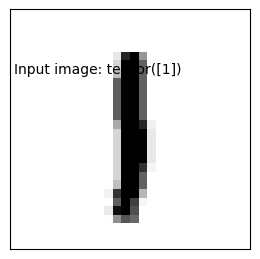

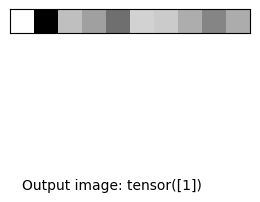

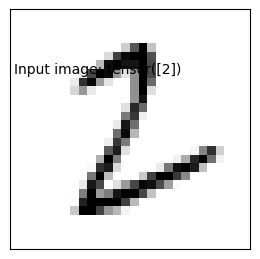

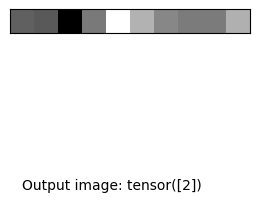

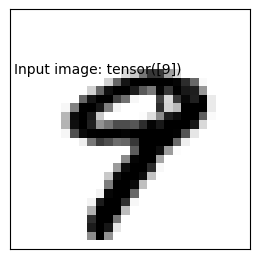

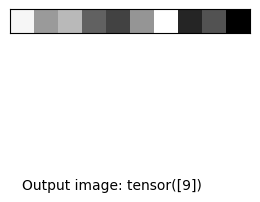

In [ ]:
# Initialize encrypted model

enc_model = EncConvNet(model)

# Test encrypted model

enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)